In [2]:
#list all json files
#read json files
#remove points in buffer region
#count points

In [3]:
import os
import math
import json
import glob

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cv2

from skimage import measure
from scipy.signal import argrelextrema
from scipy.spatial import ConvexHull
from skimage import draw

import mbb

In [4]:
image_root     = '/g/data1a/kl02/jss548/hail-research/HailPixel/subsets/images_final_hq'
json_ffn       = '/g/data1a/kl02/jss548/hail-research/HailPixel/subsets/hailpixel_20181126_final_hq_complete.json'
ref_ffn        = '/g/data1a/kl02/jss548/hail-research/HailPixel/subsets/index.csv'

out_image_path = '/g/data/kl02/jss548/hail-research/HailPixel/subset_size_extraction_image'
out_data_path  = '/g/data/kl02/jss548/hail-research/HailPixel/subset_size_extraction_data'

buffer_px    = 50


In [5]:
def PolyArea2D(pts):
    lines = np.hstack([pts,np.roll(pts,-1,axis=0)])
    area = 0.5*abs(sum(x1*y2-x2*y1 for x1,y1,x2,y2 in lines))
    return area

def find_edges(img_data):
    """
    Find edge of hail using radial of imagery data
    Applied a simple 2nd derivate check and difference checl
    """
    #calculc local min indices
    local_min_idx_list  = argrelextrema(img_data, np.less)[0]
    #calc minimum value
    min_value = np.min(img_data)
    #difference from centroid data value
    img_diff = img_data[0] - img_data
    #calc local gradient
    local_grad       = np.append([0], img_data[:-1]-img_data[1:])
    
    #init loop
    prev_value = 0
    out_idx = 0
    #compare i gradient with i-1 gradient and difference from centroid
    for i, value in enumerate(local_grad):
        if value<prev_value*0.75 and i>3 and img_diff[i]>50:
            #offset back by 1
            out_idx = i-1
            break
        else:
            prev_value = value
        
    return out_idx

In [6]:
"""
This script processes a single json image for debugging purposes
"""

def worker(json_ffn, json_idx_list, save_data):

    #open json index file
    with open(json_ffn) as json_fh:  
        data = json.load(json_fh)

    #load keys from file
    json_keys = list(data.keys())[0:]
    
    #select image for processing
    image_json = data[json_keys[json_idx_list]]

    #init output dictionary
    data_dict = {}

    #init stats
    hail_major_axis = []
    hail_minor_axis = []
    hail_area = []

    #read image
    image_fn  = image_json['filename']
    image_ffn = image_root + '/' + image_fn
    #transform into hsv colorspace
    img_data = cv2.imread(image_ffn)
    img_data_hls = cv2.cvtColor(img_data, cv2.COLOR_BGR2HLS)

    #loop through regions in annotation file
    image_region_list = image_json['regions']

    #init dict
    region_dict = {'region_idx':[],
                    'centroid_list':[], 'new_centroid_list':[],
                    'line_points':[], 'edge_idx_list':[],
                    'line_data':[], 'boundary_points':[],
                    'outlier_mask':[], 'hull_points':[],
                    'corner_points':[],
                    'hail_maj':[], 'hail_min':[], 'hail_area':[]}

    for region_idx, region in enumerate(image_region_list):

        #for regions of type point
        if region['shape_attributes']['name'] == 'point':
            cx = region['shape_attributes']['cx']
            cy = region['shape_attributes']['cy']

            #skip if in padding region
            if cx < 50 or cx > 550 or cy < 50 or cy > 550:
                continue

            #append region index
            region_dict['region_idx'].append(region_idx)

            ###########################################################
            # Step 1, refine centroid using centroid of pixels with a
            # luminosity of >200 within a bounding box of radius 4 (1.5cm)
            ###########################################################
            #
            radius_px     = 4
            #subset using radius
            subset_lum    = img_data_hls[cy-radius_px:cy+radius_px+1, cx-radius_px:cx+radius_px+1 , 1]
            masked_subset = subset_lum > 200
            #run labelling
            label_subset   = measure.label(masked_subset)
            region_subset  = measure.regionprops(label_subset)
            #for first label region
            for next_region in region_subset:
                first_region = next_region
                break
            centroid = first_region.centroid
            #calculate centroid
            new_cx = int(centroid[1])-radius_px+cx
            new_cy = int(centroid[0])-radius_px+cy
            #save centroids
            region_dict['centroid_list'].append([cx, cy]) 
            region_dict['new_centroid_list'].append([new_cx, new_cy])

            ###########################################################
            # Step 2: find edges
            ###########################################################
            #
            #configuration
            extract_range   = 16 #pixels
            azimuth_spacing = 30 #degrees
            #init azimuth list
            azimuth_list    = np.arange(0,360,azimuth_spacing)
            #init
            line_points     = []
            edge_idx_list   = []
            line_data       = []
            boundary_points = []
            dist_data       = []
            #for each azimuth
            for azi in azimuth_list:
                # create indicies for lines from centroid along search azimuth rays
                end_x    = int(new_cx + extract_range*math.cos(math.radians(azi)))
                end_y    = int(new_cy + extract_range*math.sin(math.radians(azi)))
                line_y, line_x = draw.line(new_cy, new_cx, end_y, end_x)
    #             line_x   = np.linspace(new_cx, end_x, extract_range).astype(np.int)
    #             line_y   = np.linspace(new_cy, end_y, extract_range).astype(np.int)
                # extract data along 
                data = img_data_hls[line_y, line_x, 1].astype(int)
                #run index search function
                edge_idx = find_edges(data)
                dist     = np.sqrt((new_cx-line_x[edge_idx])**2 + (new_cy-line_y[edge_idx])**2)
                boundary_points.append([line_x[edge_idx], line_y[edge_idx]])
                #store
                line_points.append([line_x, line_y])
                edge_idx_list.append(edge_idx)
                line_data.append(data)
                dist_data.append(dist)
            #store into dict
            region_dict['line_points'].append(line_points) 
            region_dict['edge_idx_list'].append(edge_idx_list)
            region_dict['line_data'].append(line_data)
            region_dict['boundary_points'].append(boundary_points)

            ###########################################################
            # Step 3: find outlier edge points
            ###########################################################

            #init
            dist_array  = np.array(dist_data).astype(float)
            dist_median = np.median(dist_array)
            dist_std    = np.std(dist_array)
            #calculate x,y for median distance
            end_x_median = new_cx + dist_median*np.cos(np.radians(azimuth_list))
            end_y_median = new_cy + dist_median*np.sin(np.radians(azimuth_list))
            #find outliers
            factor = 0.75
            outlier_mask = np.logical_or(dist_array<(dist_median-(dist_median*factor)), dist_array>(dist_median+(dist_median*factor)))
            #mask boundary to remove outliers
            region_dict['outlier_mask'].append(outlier_mask)
            #update outliers with median x,y values for that radial
            boundary_points_array = np.array(boundary_points)
            for idx in np.where(outlier_mask)[0]:
                boundary_points_array[idx] = [end_x_median[idx], end_y_median[idx]]

            ###########################################################
            # Step 4: take convex hull and bounding box
            ###########################################################

            #convert boundary points to polygon using convexhull
            try:
                hull = ConvexHull(boundary_points_array)
            except:
                print('failed on convexhull')
                continue
            #extract vertex list
            vertex_idx_list = hull.vertices #always in clockwise order
            #append first vertex to close polygon
            vertex_idx_list = np.append(vertex_idx_list,vertex_idx_list[0])
            #use vertex list to extract points
            hull_points = boundary_points_array[vertex_idx_list,:]
            #compute stats
            bounding_box = mbb.MinimumBoundingBox(hull_points)
            corner_points = list(bounding_box.corner_points)
            #save
            region_dict['hull_points'].append(hull_points)
            region_dict['corner_points'].append(corner_points)

            ###########################################################
            # Step 5: Genreate stats
            ###########################################################

            len_parallel   = bounding_box.length_parallel
            len_orthogonal = bounding_box.length_orthogonal
            poly_area      = PolyArea2D(hull_points)
            #work out maj/min axis length
            if len_parallel>len_orthogonal:
                maj_axis, min_axis = len_parallel, len_orthogonal
            else:
                maj_axis, min_axis = len_orthogonal, len_parallel
            #save
            region_dict['hail_maj'].append(maj_axis)
            region_dict['hail_min'].append(min_axis)
            region_dict['hail_area'].append(poly_area)

            
    if save_data:
        data_ffn = out_data_path + '/' + image_fn[:-4] + '.csv'
        csv_data = np.column_stack((region_dict['hail_maj'], region_dict['hail_min'], region_dict['hail_area']))
        np.savetxt(data_ffn, csv_data, delimiter=",", fmt='%5.1f')
        
    print('finished processing', str(len(region_dict['hail_area'])), 'hail stones') 

    return img_data, image_fn, region_dict

#code to run within this cell
json_idx_list = 12
img_data, image_fn, region_dict = worker(json_ffn, json_idx_list, False)

finished processing 74 hail stones


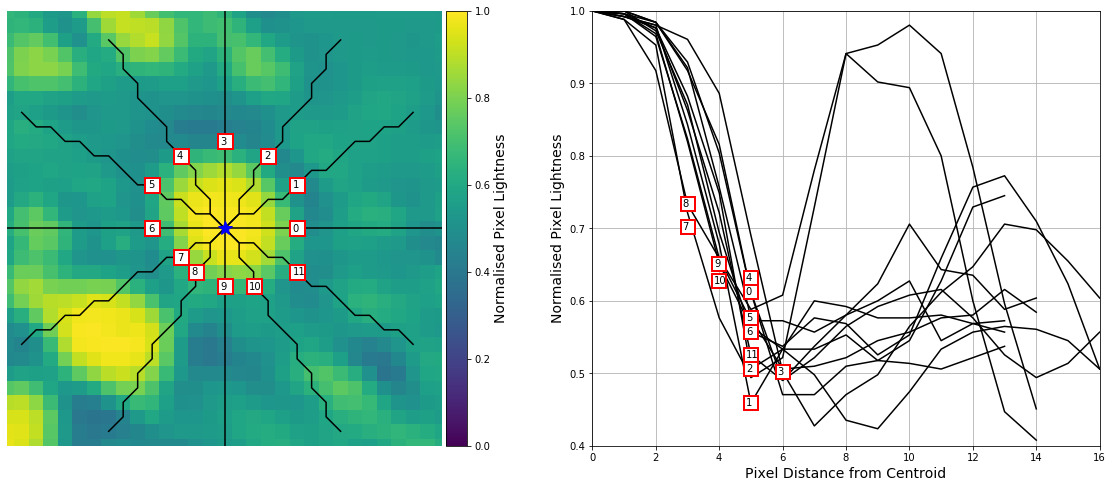

In [7]:
#plot single

#plotting of radial plots of luminosity of a hailstone
region_index = 20

#init plot
fig, axes = plt.subplots(nrows=1, ncols=2, facecolor='white',figsize=[20, 8])

#find index of hail data
plot_idx = region_dict['region_idx'].index(region_index)

#extract data
line_data        = region_dict['line_data'][plot_idx]
[new_cx, new_cy] = region_dict['new_centroid_list'][plot_idx]
boundary_points  = region_dict['boundary_points'][plot_idx]
edge_idx_list    = region_dict['edge_idx_list'][plot_idx]
outlier_list     = np.where(region_dict['outlier_mask'][plot_idx])[0]
line_points      = region_dict['line_points'][plot_idx]
#show luminosity image
img_data_lsv = cv2.cvtColor(img_data, cv2.COLOR_BGR2HLS)
im = axes[0].imshow(img_data_lsv[:,:,1]/255, vmin=0, vmax=1)
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = fig.colorbar(im, cax=cax, orientation='vertical')
cb.set_label(label='Normalised Pixel Lightness', fontsize=14)
#plot rgb image
#axes[0].imshow(img_data[:,:,::-1]) #invert colours # RGB-> BGR
axes[0].axis('off')
#zoom to hail
axes[0].set_xlim([new_cx-15, new_cx+15])
axes[0].set_ylim([new_cy-15, new_cy+15])



for i,_ in enumerate(boundary_points):
    #plot radial
    axes[0].plot(line_points[i][0], line_points[i][1], 'k-')

    #plot edge on image
    if i in outlier_list:
        axes[0].plot(boundary_points[i][0], boundary_points[i][1], 'bs', markersize=15, markerfacecolor="w", markeredgewidth=2)
    else:
        axes[0].plot(boundary_points[i][0], boundary_points[i][1], 'rs', markersize=15, markerfacecolor="w", markeredgewidth=2)
    #plot text points
    axes[0].text(boundary_points[i][0]-0.3, (boundary_points[i][1]-0.2), str(i), color='k')
    
    #plot line
    axes[1].plot(line_data[i]/255, 'k-')
    axes[1].set_xlim([0,16])
    axes[1].set_ylim([0.4,1])
    axes[1].grid('on')
    
for i,_ in enumerate(boundary_points):    

    #offset some makrers to remove overlap
    x_coord = edge_idx_list[i]
    y_coord =  line_data[i][edge_idx_list[i]]
    if i == 10:
        y_coord = y_coord-8
    if i == 4:
        y_coord = y_coord+5
    if i == 7:
        y_coord = y_coord-5 
    #plot line edge marker
    if i in outlier_list:
        axes[1].plot(x_coord, y_coord/255, 'bs', markersize=14, markerfacecolor="w", markeredgewidth=2)
    else:
        axes[1].plot(x_coord, y_coord/255, 'rs', markersize=14, markerfacecolor="w", markeredgewidth=2)
    #plot line edge marker index
    axes[1].text(x_coord-0.16, (y_coord-1)/255, str(i))

#plot centroid
axes[0].plot(new_cx, new_cy, 'b*', markersize=15)

#axis labels
axes[1].set_xlabel('Pixel Distance from Centroid', fontsize=14)
axes[1].set_ylabel('Normalised Pixel Lightness', fontsize=14)
    
plt.savefig('single_hail_figure.png', dpi=150)
        

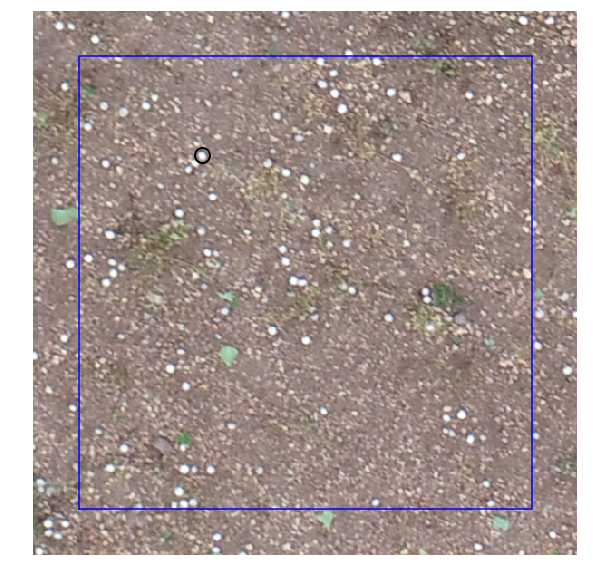

In [68]:
#plotting all

def plot_global(img_data, image_fn, region_dict, save_flag):
    
    """
    plot all images
    """
    
    #plot rgb image with padding box
    fig = plt.figure(facecolor='white',figsize=[10, 10])
    plt.plot([50,50,550,550,50],[50,550,550,50,50],'b-')
    plt.imshow(img_data[:,:,::-1]) #invert colours # RGB-> BGR
    plt.gca().invert_yaxis()
    plt.axis('off')

    #for every region
    for i, region_idx in enumerate(region_dict['region_idx']):
        #plot rcnn centroid
        [cx, cy] = region_dict['centroid_list'][i]
        #plt.plot(cx, cy, 'r.')

        #plot adjusted centroid
        [new_cx, new_cy] = region_dict['new_centroid_list'][i]
        #plt.plot(new_cx,new_cy,'b.')   
        #plot index
        #plt.text(new_cx+0.5, new_cy+0.5, str(region_dict['region_idx'][i]))
        #plot cenvex hull
        try:
            hull_points = region_dict['hull_points'][i]
            if region_idx == 20:
                plt.plot(new_cx,new_cy+2,'ko', markersize=15, markerfacecolor='none', markeredgewidth=2)
            #plt.plot(hull_points[:,0],hull_points[:,1],'k-', linewidth=1.0)
        except:
            print('missing hull info for plotting')
#     #plot bounding box
#     corner_points = region_dict['corner_points'][i]
#     corner_points_x = [corner_points[0][0], corner_points[1][0], corner_points[2][0], corner_points[3][0], corner_points[0][0]]
#     corner_points_y = [corner_points[0][1], corner_points[1][1], corner_points[2][1], corner_points[3][1], corner_points[0][1]]
#     plt.plot(corner_points_x, corner_points_y, 'w-')
    if save_flag:
        img_ffn = out_image_path + '/' + image_fn
        plt.savefig(img_ffn, dpi=75)
        plt.close()
        

#code to run within cell
plot_global(img_data, image_fn, region_dict, False)
plt.savefig('subset_figure.png', dpi=150)


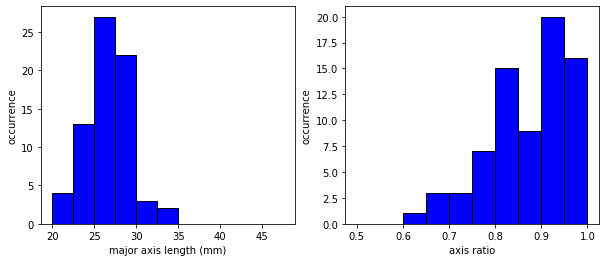

In [8]:
#plot distributions
def plot_stats(hail_maj, hail_min):
    pixel_scaling = 2.54 #mm/pixel
    
    #apply scaling
    hail_maj = hail_maj*pixel_scaling
    hail_min = hail_min*pixel_scaling
    
    # matplotlib histogram
    fig = plt.figure(facecolor='white',figsize=[10, 4])

    plt.subplot(1, 2, 1)
    plt.hist(hail_maj, color = 'blue', edgecolor = 'black', bins=np.arange(20,50,2.5))
    plt.xlabel('major axis length (mm)')
    plt.ylabel('occurrence')

    plt.subplot(1, 2, 2)
    plt.hist(hail_min/hail_maj, color = 'blue', edgecolor = 'black', bins=np.arange(0.5,1.05,0.05))
    plt.xlabel('axis ratio')
    plt.ylabel('occurrence')


hail_major_axis_array = np.array(region_dict['hail_maj'])
hail_minor_axis_array = np.array(region_dict['hail_min'])

plot_stats(hail_major_axis_array, hail_minor_axis_array)

In [11]:
#open json index file
with open(json_ffn) as json_fh:  
    data = json.load(json_fh)
#check number of files
n_files = len(list(data.keys())[0:])

#init
hail_major_axis_array = np.array([])
hail_minor_axis_array = np.array([])
hail_area_array       = np.array([])

for i in range(0, n_files):
    #process data
    img_data, image_fn, region_dict = worker(json_ffn, i, True)
    
    #plot data
    #plot_global(img_data, image_fn, region_dict, True)
    
    np.save('size_data/'+image_fn[0:4]+'_major.npy', region_dict['hail_maj'])
    np.save('size_data/'+image_fn[0:4]+'_minor.npy', region_dict['hail_min'])
    
    #save extracted size,, 
    
    #append stats
    hail_major_axis_array = np.append(hail_major_axis_array, region_dict['hail_maj'])
    hail_minor_axis_array = np.append(hail_minor_axis_array, region_dict['hail_min'])
    hail_area_array       = np.append(hail_area_array, region_dict['hail_area'])
    
    #update user
    print('finished', i)

np.save('size_data/all_major.npy',hail_major_axis_array)
np.save('size_data/all_minor.npy',hail_minor_axis_array)

finished processing 69 hail stones
finished 0
finished processing 74 hail stones
finished 1
finished processing 99 hail stones
finished 2
finished processing 102 hail stones
finished 3
finished processing 88 hail stones
finished 4
finished processing 88 hail stones
finished 5
finished processing 127 hail stones
finished 6
finished processing 93 hail stones
finished 7
finished processing 85 hail stones
finished 8
finished processing 101 hail stones
finished 9
finished processing 91 hail stones
finished 10
finished processing 115 hail stones
finished 11
finished processing 74 hail stones
finished 12
finished processing 98 hail stones
finished 13
finished processing 74 hail stones
finished 14
finished processing 129 hail stones
finished 15
finished processing 111 hail stones
finished 16
finished processing 103 hail stones
finished 17
finished processing 124 hail stones
finished 18
finished processing 86 hail stones
finished 19
finished processing 84 hail stones
finished 20
finished proces

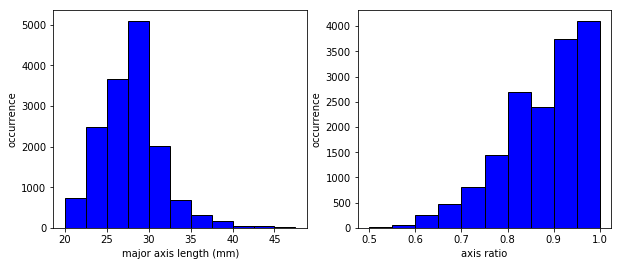

In [25]:
hail_major_axis_array = np.load('all_major.npy')
hail_minor_axis_array = np.load('all_minor.npy')

plot_stats(hail_major_axis_array, hail_minor_axis_array)